In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tifffile

from figure_utils import make_event, array_events, event

In [2]:
from figure_utils import basic_event_iterator, collapse_2d, collapse_2d_polarity, numpify_df
from eventcamprocessing import filter_funcs

In [17]:
data_path = Path("../scripts/data/csv_files")
save_path = Path("./output")

# showcase Joanna's testcases as synthetic noise

In [37]:
def plot_filter(events, filtered_events, name="filter"):
    fig, axes = plt.subplots(1, 2, figsize=(6, 4))
    original_collapsed = collapse_2d(arr, (10, 10))
    final_collapsed = collapse_2d(out, (10, 10))

    vmax = original_collapsed.max()

    axes[0].imshow(original_collapsed, cmap="gray", vmax=vmax)
    axes[0].set_title("Original Events")
    axes[0].axis("off")
    axes[1].imshow(final_collapsed, cmap="gray", vmax=vmax)
    axes[1].set_title("Filtered Events")
    axes[1].axis("off")

    plt.savefig(save_path / f"{name}_comparison.png", dpi=300)
    plt.show()


def plot_filter_polarity(events, filtered_events, name="filter"):
    fig, axes = plt.subplots(1, 2, figsize=(6, 4))
    original_collapsed_on, original_collapsed_off = collapse_2d_polarity(arr, (10, 10))
    final_collapsed_on, final_collapsed_off = collapse_2d_polarity(out, (10, 10))

    vmax = max(original_collapsed_on.max(), original_collapsed_off.max())

    original_combined = np.dstack((original_collapsed_off, original_collapsed_on, np.zeros_like(original_collapsed_on)))
    original_combined = (original_combined / vmax)
    final_combined = np.dstack((final_collapsed_off, final_collapsed_on, np.zeros_like(final_collapsed_on)))
    final_combined = (final_combined / vmax)

    axes[0].imshow(original_combined, vmax=vmax)
    axes[0].set_title("Original Events")
    axes[0].axis("off")
    axes[1].imshow(final_combined, cmap="gray", vmax=vmax)
    axes[1].set_title("Filtered Events")
    axes[1].axis("off")

    plt.tight_layout()

    plt.savefig(save_path / f"{name}_comparison.png", dpi=300)
    plt.show()

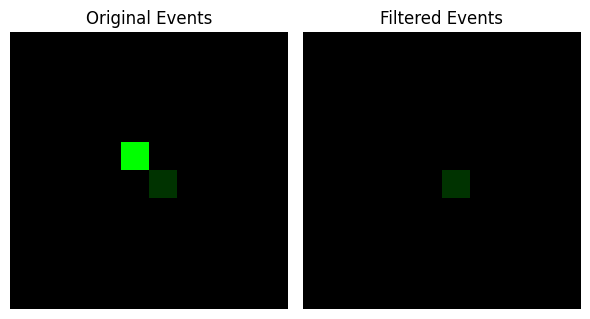

In [38]:
fast = [(4, 4, t, 1) for t in range(0, 1000, 50)]
slow = [(5, 5, t, 1) for t in range(0, 2000, 500)]

arr = array_events(fast + slow)
out = filter_funcs.low_pass_filter(arr, min_dt=300, min_count=5)

plot_filter_polarity(arr, out, name="low_pass_filter")

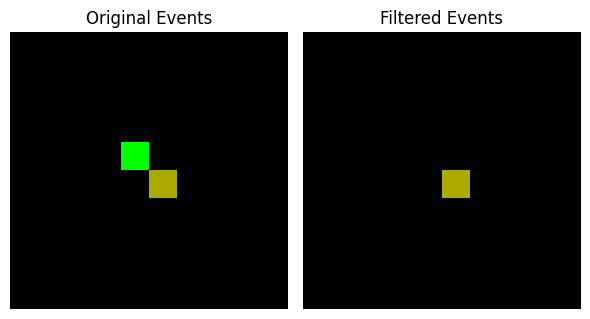

In [39]:
events = []
events += [(4, 4, t, 1) for t in (0, 5000, 10000)]
events += [(5, 5, t, p) for t, p in zip((0, 3000, 6000, 10000), (1, -1, 1, -1))]

arr = array_events(events)
out = filter_funcs.hot_pixel_filter(arr, min_duration=8000)

plot_filter_polarity(arr, out, name="hot_pixel_filter")

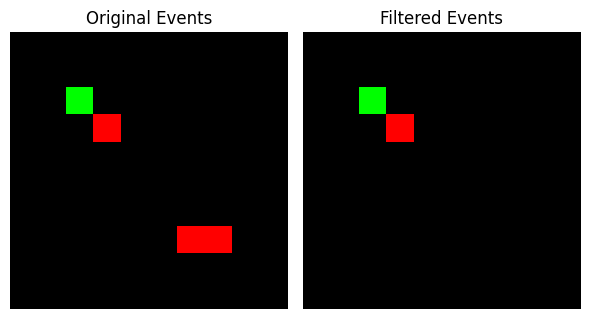

In [40]:
arr = array_events([(2, 2, 1000, 1),
                    (3, 3, 1005, -1),
                    (6, 7, 1000, -1),
                    (7, 7, 1000, -1),
                    ])

out = filter_funcs.opposite_polarity_filter(arr, spatial_radius=4, time_scale=1e-3)

plot_filter_polarity(arr, out, name="opposite_polarity_filter")


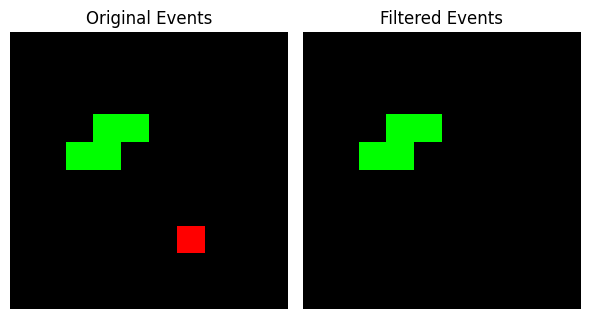

In [41]:
arr = array_events([
            (3, 4, 1000, 1),
            (3, 3, 1000, 1),
            (4, 3, 1001, 1),
            (6, 7, 2000, -1),  # isolated event
            (2, 4, 1002, 1),
        ])
out = filter_funcs.isolated_noise_filter(arr, spatial_radius=2, time_window=5, min_neighbors=3)

plot_filter_polarity(arr, out, name="isolated_noise_filter")



In [43]:

dfs = [pd.read_csv(f) for f in data_path.glob("*.csv")]

df = dfs[0]

In [6]:
from figure_utils import basic_event_iterator, collapse_2d, numpify_df

1279 719
4446607


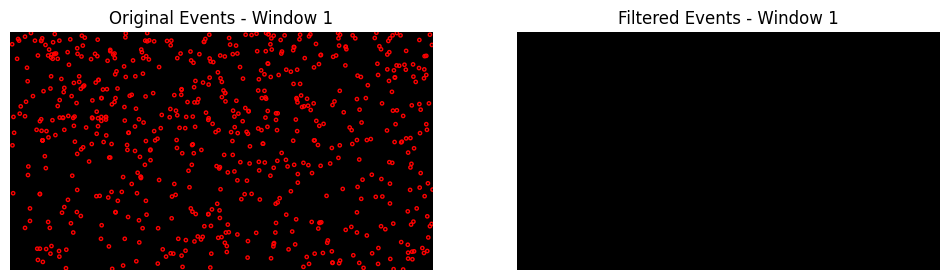

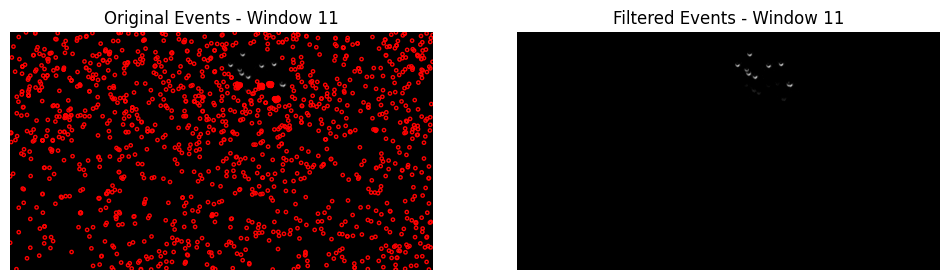

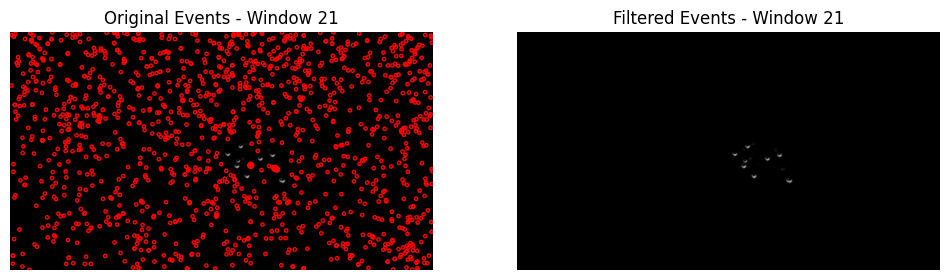

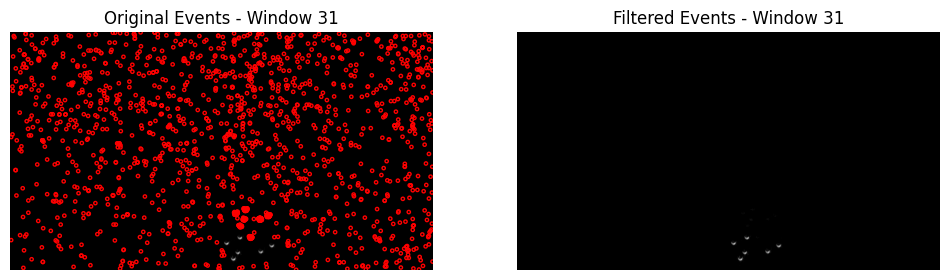

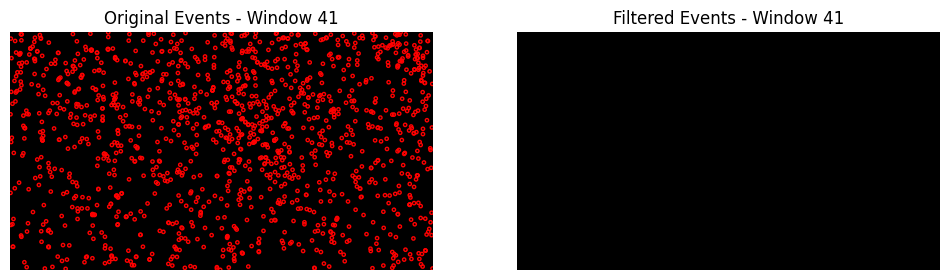

In [46]:
from eventcamprocessing import filter_funcs

events = numpify_df(df)

print(events["x"].max(), events["y"].max())
print(events["t"].max())

t_step = 100000  # in microseconds
t_window = 20000  # in microseconds
shape = (720, 1280)

output_stack = []

for i, window_events in enumerate(basic_event_iterator(events, t_step, t_window)):
    window_events = window_events[window_events["p"] == 1]

    # Original collapsed image
    img_original = collapse_2d(window_events, shape)

    # Filtered events
    filtered_events = filter_funcs.isolated_noise_filter(
        window_events, spatial_radius=20, time_window=500, min_neighbors=5
    )
    img_filtered = collapse_2d(filtered_events, shape)

    removed_events = [
        e for e in window_events.tolist() if e not in filtered_events.tolist()
    ]

    stacked = np.hstack((img_original, img_filtered))
    output_stack.append(stacked)

    if i % 10 != 0:
        continue

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot original
    axes[0].imshow(img_original, cmap="gray")
    axes[0].set_title(f"Original Events - Window {i + 1}")
    axes[0].axis("off")

    # circle removed events
    for e in removed_events:
        circ = plt.Circle((e[0], e[1]), radius=5, color="red", fill=False, linewidth=1)
        axes[0].add_patch(circ)

    # Plot filtered
    axes[1].imshow(img_filtered, cmap="gray")
    axes[1].set_title(f"Filtered Events - Window {i + 1}")
    axes[1].axis("off")

    plt.show()

tifffile.imwrite(
    save_path / "filter_comparison.tiff",
    np.array(output_stack, dtype=np.uint8),
)